# Lab Assignment Three: Extending Logistic Regression

### Authors
- Juliana Antonio
- Xiaona Hang
- Chuanqi Deng


### 1. Preparation and Overview

The "Body Performance Data" sourced from the [Korea Sports Promotion Foundation](https://www.bigdata-culture.kr/bigdata/user/data_market/detail.do?id=ace0aea7-5eee-48b9-b616-637365d665c1), available on Kaggle, comprises 13,393 rows and encompasses 12 features, such as age, gender, height, weight, and more. This dataset, meticulously curated, demonstrates the correlation between age and various exercise performance metrics, thereby providing insights into individual performance grades.

Utilizing this rich dataset, the aim is to classify individuals into distinct performance grades: A (Best), B, C, and D (Worst), based on the aforementioned 12 features. This classification is pivotal for tailoring personalized training plans, catering to diverse needs and abilities. Consequently, gyms and rehabilitation centers stand to benefit significantly from leveraging predictive analytics to craft bespoke training plans, optimizing clients' progress and well-being.

Beyond professional institutions, individuals themselves will be interested in understanding their body performance classification. Armed with this knowledge, they can make informed decisions regarding their fitness journey, setting realistic goals and embracing tailored approaches for holistic improvement.

The deployment of a robust classification model is expected to achieve an accuracy of approximately 80%. By meeting this benchmark, the model ensures reliable predictions, empowering stakeholders to make data-driven decisions with confidence.


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from numpy.linalg import pinv
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm

raw_data = pd.read_csv("data/bodyPerformance.csv")

# preprocessing
data = pd.get_dummies(raw_data, columns=['gender'],dtype=np.int8) # one-hot encoding for gender
labels = data['class'].map(lambda c: ord(c) - ord('A')) # encode lables into integer
data.drop(['class'], axis=1, inplace=True) # remove class column

# scale
scaler = StandardScaler()
features = scaler.fit_transform(data)

# PCA
pca = PCA(8)
pca_feature = pca.fit_transform(features)
raw_data.shape, pca_feature.shape

((13393, 12), (13393, 8))

The dataset has one categorical feature, the gender. One-hot encoding is enployed to convert it into numerical data. Next, the lables/class is moved to another separate variable, lables. Then, the Standard Scaling and PCA are applied to mitigate the difference of multiple features reduce the number of features from 12 to 8.

In [2]:
# breakdown of the variables
pd.DataFrame(pca_feature).describe()

,0,1,2,3,4,5,6,7
count,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04
mean,-8.488527e-18,4.138157e-17,2.652665e-18,1.591599e-17,-1.432439e-17,-3.978997e-18,2.546558e-17,9.019060e-18
std,2.386378e+00,1.462662e+00,1.127011e+00,9.438121e-01,8.081770e-01,5.785046e-01,5.602344e-01,4.860709e-01
min,-5.041796e+00,-5.384663e+00,-7.437324e+00,-4.140902e+00,-4.012083e+00,-2.242237e+00,-5.062883e+00,-2.246422e+00
25%,-1.967484e+00,-1.012307e+00,-6.911124e-01,-6.042082e-01,-4.971976e-01,-3.845767e-01,-3.517389e-01,-3.142285e-01
50%,-8.995369e-01,1.073930e-01,5.143689e-02,1.506179e-02,7.247022e-03,1.665698e-02,8.867419e-03,-3.037003e-03
75%,2.360703e+00,1.072822e+00,7.628835e-01,6.133066e-01,5.253231e-01,3.905508e-01,3.792356e-01,3.000243e-01
max,6.506510e+00,7.782459e+00,1.473913e+01,4.345014e+00,1.360873e+01,3.636507e+00,5.873632e+00,6.967697e+00


In [4]:
# test different folds of cross validation
cross_validation_accs = {}
# n fold cross-validation, n: 3-10
for n in tqdm(range(3, 11)):
    # n-fold cross-validation
    cross_validator = KFold(n_splits=n)
    split_indices = cross_validator.split(pca_feature, labels)
    
    # training and testing
    avg_accs = []
    for train_indices, test_indices in split_indices:
        X_train, y_train = pca_feature[train_indices], labels[train_indices]
        X_test, y_test = pca_feature[test_indices], labels[test_indices]
        
        classifier = SVC()
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        avg_accs.append(acc)
    
    cross_validation_accs[n] = avg_accs

100%|██████████| 8/8 [01:32<00:00, 11.53s/it]


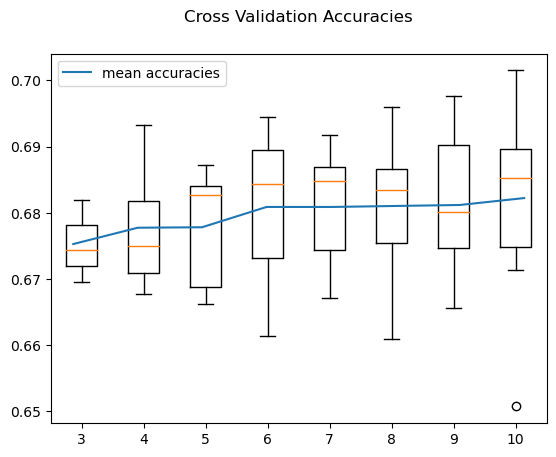

In [5]:
# plot cross validation accuracies
plt.boxplot(cross_validation_accs.values(), labels=list(range(3, 11)))
ax = plt.twiny()
avg_accs = [np.mean(accs) for accs in cross_validation_accs.values()]
ax.plot(avg_accs, label='mean accuracies')
ax.set_axis_off()
ax.legend(loc = 'upper left')
plt.title("Cross Validation Accuracies");

According to the graph above, it is clear that the 7-fold cross-validation has the best accuracies, considering the stablity and median accuracy. Hence, a rougly 86/14 split would be ideal for this dataset.

In [6]:
# use the optimal number of folds for the following analysis
cross_validator = KFold(n_splits=7)
split_indices = cross_validator.split(pca_feature, labels)

#### Performance Comparison with Scikit-learn

In [13]:
%%time
lr_sk = SKLogisticRegression() # all params default
lr_sk.fit(X_train,y_train)
print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
yhat = lr_sk.predict(X_test)

accuracy = accuracy_score(y_test, yhat)
#precision = precision_score(y_test, yhat, average='weighted')  
#recall = recall_score(y_test, yhat, average='weighted')  
#f1 = f1_score(y_test, yhat, average='weighted')  

print("Accuracy:", accuracy)
#print("Precision:", precision)
#print("Recall:", recall)
#print("F1 Score:", f1)

[[-0.87789422 -0.101442    1.18621727  1.96995561 -1.15799033  1.09182613
   0.61306582 -0.06642085 -1.64344834]
 [ 0.64356991 -0.0510562   0.31407293  0.51933262 -0.39710115  0.23432896
   0.19385591 -0.03192305 -0.47919619]
 [ 0.82911576  0.0087344  -0.23712494 -0.53454181  0.20028942 -0.45432026
  -0.35322607 -0.00691083  0.44089941]
 [-0.59479145  0.1437638  -1.26316527 -1.95474642  1.35480206 -0.87183483
  -0.45369566  0.10525473  1.68174512]]
Accuracy: 0.607916355489171
CPU times: user 936 ms, sys: 78.6 ms, total: 1.01 s
Wall time: 176 ms


In [18]:
%%time
from sklearn.linear_model import LogisticRegressionCV
log_model = LogisticRegressionCV()
log_model.fit(X_train , y_train)
print(np.hstack((log_model.intercept_[:,np.newaxis],log_model.coef_)))
y_pred = log_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[[-0.86774917 -0.10056169  1.17580552  1.95125441 -1.14557507  1.08006044
   0.60556786 -0.06542862 -1.61896257]
 [ 0.63679276 -0.05070692  0.31066396  0.51379461 -0.39289505  0.2319522
   0.19193319 -0.03159581 -0.47068844]
 [ 0.82024256  0.00844009 -0.23422514 -0.5286112   0.196802   -0.44997806
  -0.35011905 -0.0070676   0.4343472 ]
 [-0.58928615  0.14282852 -1.25224435 -1.93643781  1.34166812 -0.86203459
  -0.447382    0.10409203  1.65530381]]
Accuracy: 0.6071695294996265
CPU times: user 8.33 s, sys: 629 ms, total: 8.96 s
Wall time: 1.22 s


### 3. Deployment

Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party implementation)? Why?


### 4. Exceptional Work

Implement an optimization technique for logistic regression using mean square error as your objective function (instead of maximum likelihood). Derive the gradient updates for the Hessian and use Newton's method to update the values of "w". Then answer, which process do you prefer: maximum likelihood OR minimum mean-squared error?

#### Mean Squared Error (MSE) Approach 

In logistic regression, the Mean Squared Error (MSE) approach minimizes the squared difference between predicted probabilities and actual labels.

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$

The gradient of the MSE loss with respect to the weights is computed as:

$$
\nabla l(\mathbf{w}) = \frac{1}{N} \mathbf{X}^T (\mathbf{y} - \hat{\mathbf{y}})
$$

where:
- $\mathbf{X}$ is the design matrix
- $\mathbf{y}$ is the true labels
- $\hat{\mathbf{y}}$ is the predicted labels

We compute the gradient of the MSE loss function with respect to the model parameters and update the parameters iteratively until convergence.

The Hessian matrix is computed as:

$$
\mathbf{H} = \frac{1}{N} \mathbf{X}^T \mathbf{X}
$$

Using Newton's method, we iteratively update the weights as:

$$
\mathbf{w}_{\text{new}} = \mathbf{w}_{\text{old}} - (\mathbf{H}^{-1} \nabla l(\mathbf{w}_{\text{old}}))
$$


In [19]:
# Logistic Regression with MSE
class LogisticRegressionMSE:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        self.weights = None  # Initialize weights
        
    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.w_ = np.zeros((num_features + 1, 1))
        X = np.c_[np.ones((num_samples, 1)), X]  # Add intercept
        
        for _ in range(self.iters):
            y_pred = self._sigmoid(X @ self.w_)
            y_pred = y_pred.flatten()
            gradient = X.T @ (y_pred - y) / num_samples
            hessian = X.T @ X / num_samples
            gradient = gradient.reshape(-1, 1) # Reshape gradient to ensure it's treated as a column vector
            self.w_ -= self.eta * np.linalg.inv(hessian) @ gradient # Update the model parameters using Newton's method
        
        self.weights = self.w_  # Store weights
    
    def predict_proba(self, X):
        X = np.c_[np.ones((X.shape[0], 1)), X]
        return self._sigmoid(X @ self.w_)
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        return (probabilities >= 0.5).astype(int)
    
    def _sigmoid(self, z):
        z_clipped = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z_clipped))

In [20]:
%%time
from sklearn.metrics import accuracy_score

lr_mse = LogisticRegressionMSE(eta=0.1, iterations=1000)

lr_mse.fit(X_train, y_train)
y_pred = lr_mse.predict(X_test)
print(np.vstack((lr_mse.weights[0], lr_mse.weights[1:])))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


[[ 64.79848844]
 [  2.64184154]
 [-24.57731991]
 [-38.6076736 ]
 [ 24.13270136]
 [-18.40053991]
 [-11.75170579]
 [  2.56745457]
 [ 36.07685944]]
Accuracy: 0.3286034353995519
CPU times: user 5.77 s, sys: 518 ms, total: 6.29 s
Wall time: 903 ms


In [21]:
class LogisticRegressionMSEOvR: # One vs. All multiclass with MSE
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        self.classifiers = {}  # Dictionary to store binary classifiers
        
    def fit(self, X, y):
        num_samples, num_features = X.shape
        unique_classes = np.unique(y)
        
        for class_label in unique_classes:
            y_binary = (y == class_label).astype(int)  # Convert to binary labels
            classifier = LogisticRegressionMSE(self.eta, self.iters)
            classifier.fit(X, y_binary)
            self.classifiers[class_label] = classifier
    
    def predict_proba(self, X):
        num_samples = X.shape[0]
        probabilities = np.zeros((num_samples, len(self.classifiers)))
        
        for i, (class_label, classifier) in enumerate(self.classifiers.items()):
            probabilities[:, i] = classifier.predict_proba(X).flatten()
        
        return probabilities
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)


In [22]:
%%time
lr_ovr = LogisticRegressionMSEOvR(eta=0.1, iterations=1000)
# Fit the model to your data
lr_ovr.fit(X_train, y_train)
# Make predictions
y_pred = lr_ovr.predict(X_test)
weights_stacked = np.hstack([lr_ovr.classifiers[class_label].weights for class_label in lr_ovr.classifiers])
print(weights_stacked)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[[-2.19241914 -1.16532679 -1.12508868 -2.04419283]
 [-0.06983582 -0.03754399 -0.01452815  0.14460761]
 [ 1.00182664  0.15717914 -0.01487167 -1.14735612]
 [ 1.68235237  0.31305685 -0.11608272 -1.67110059]
 [-0.90371917 -0.27550582 -0.11695972  1.27001458]
 [ 0.9855471   0.19525896 -0.20261799 -0.60294016]
 [ 0.55358196  0.14641481 -0.30372488 -0.26616815]
 [-0.04856833 -0.02482165  0.00420405  0.11835526]
 [-1.42036244 -0.18368465  0.3066078   1.47719106]]
Accuracy: 0.5937266616878267
CPU times: user 21.5 s, sys: 1.7 s, total: 23.2 s
Wall time: 3.23 s


References:
1. https://www.kaggle.com/datasets/kukuroo3/body-performance-data
2. https://www.bigdata-culture.kr/bigdata/user/data_market/detail.do?id=ace0aea7-5eee-48b9-b616-637365d665c1